# Environment setup

## Downloading the code and the dataset


First off, we'll be installing the required dependencies with `pip`:


In [1]:
!pip --quiet install imagecodecs tifffile stardist gdown

Then we obtain the code from the GitHub repository and `cd` into its directory:

In [2]:
!git clone 'https://github.com/CRefice/ml-segmentation-project.git' --quiet
%cd ml-segmentation-project/

fatal: destination path 'ml-segmentation-project' already exists and is not an empty directory.
/content/ml-segmentation-project


The GitHub repository features a handy script to download the dataset, so we just run it:

In [3]:
!./fetch-data.sh

Dataset already downloaded.


## Useful imports and settings

Before running any code, we import all the required packages, functions and modules. We also initialize some variables such as the default device to use while training (GPU if available) and the random seed.

In [52]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np
from skimage import measure

from stardist import random_label_cmap
from tqdm import tqdm
from stardist.matching import matching_dataset
from stardist.models import StarDist2D


import unet
from dataset import *
from train import train_model
from losses import *
from losses import CombinedLoss, DiceLoss
from watershed import label_with_watershed

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Defining the dataset and data transformations

We have previously downloaded the dataset. Now we define the objects that will load it into memory and perform the required transformations. That includes augmentations, which will greatly increase the size of the dataset (and thus the training time.) To avoid that, leave the `AUGMENT_DATASET` checkbox unchecked.

The other parameter to edit is `NUM_CLASSES`, which dictates whether the U-Net will be trained for binary (background-foreground) classification or three-class (with border) segmentation.

In [40]:
AUGMENT_DATASET = False #@param {type:"boolean"}

IMG_SIZE = 1024
NUM_CLASSES = 3 #@param {type:"slider", min:2, max:3, step:1}

image_transform = transforms.Compose([
    NormalizeMinMax(),  
    transforms.ToTensor(),
    PadToSize(IMG_SIZE),
])

target_transform = transforms.Compose([
    InstanceToTwoClass() if NUM_CLASSES == 2 else InstanceToThreeClass(),
    transforms.ToTensor(),
    PadToSize(IMG_SIZE),
    transforms.ConvertImageDtype(torch.float32 if NUM_CLASSES == 2 else torch.long),
    # We need to add a dimension to 2-class case since loss functions
    # expect a "channel" dimension whereas 3-class loss functions don't
    transforms.Lambda(lambda img: img.squeeze() if NUM_CLASSES == 3 else img),
])

if not AUGMENT_DATASET:
    dataset = CellSegmentationDataset(raw_img_dir=Path("dataset/rawimages"),
                                  ground_truth_dir=Path("dataset/groundtruth"),
                                  transform=image_transform,
                                  target_transform=target_transform
                                )
else:
    def rotation(degrees):
        return lambda img: TF.rotate(img, degrees)

    augmentations = [
        TF.hflip,
        TF.vflip,
        lambda img: TF.hflip(TF.vflip(img)),
        rotation(90),
        rotation(180),
        rotation(270),
    ]
    dataset = AugmentedCellSegmentationDataset(raw_img_dir=Path("dataset/rawimages"),
                                  ground_truth_dir=Path("dataset/groundtruth"),
                                  augmentations=augmentations,
                                  transform=image_transform,
                                  target_transform=target_transform
    )

As a final step, we split the dataset into a train set and a validation set, before creating `DataLoader` objects that will schedule the loading of the images into batches. The ratio of train data out of the entire dataset can be controlled with the slider below.

In [6]:
TRAIN_PERCENT = 0.8 #@param {type:"slider", min:0, max:1, step:0.05}
BATCH_SIZE = 2

train_size = int(len(dataset) * TRAIN_PERCENT)
test_size = len(dataset) - train_size

idx = np.random.permutation(len(dataset))
train_idx = idx[:train_size]
val_idx = idx[:test_size]

train_dataset = data.Subset(dataset, train_idx)
val_dataset = data.Subset(dataset, val_idx)
# train_dataset, val_dataset = data.random_split(dataset, [train_size, test_size])

train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

# U-Net Segmentation

Let's start by defining the U-Net model we'll be using to segment images:

In [7]:
model = unet.UNet(num_classes=NUM_CLASSES).to(device)

Now, we could train the model "live" directly on the dataset, or we could download a model we previously trained on the same data. Choose one of the following options, depending on the amount of time you have ;)

## Option 1: Training the U-Net

Try editing the parameters in the following cell to affect the training process (especially TRN_EPOCHS and LEARNING_RATE).

In [8]:
TRN_EPOCHS = 20
WEIGHT_DECAY = 0
LEARNING_RATE = 0.001
MOMENTUM = 0.99

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
if NUM_CLASSES == 2:
    criterion = nn.BCEWithLogitsLoss()
else:
    labels_dataset = (label for image, label in train_loader)
    weights = find_class_weights(NUM_CLASSES, labels_dataset).to(device)
    criterion = CombinedLoss(
        nn.CrossEntropyLoss(weights),
        DiceLoss()
    )

In [9]:
torch.cuda.empty_cache()
model, _ = train_model(device, model, optimizer, criterion, train_loader, val_loader, num_epochs=TRN_EPOCHS)

Epoch 1/20
----------
Epoch train loss: nan
Epoch validation loss: nan
Took 1m 1s

Epoch 2/20
----------
Epoch train loss: nan


KeyboardInterrupt: ignored

## Option 2: Loading a pre-trained model

Run the following cell to download the model from our Google Drive (should be really quick). The model downloaded also depends on `NUM_CLASSES` as set previously.

In [32]:
import gdown

URL_2_CLASS = "https://drive.google.com/uc?id=1yjGfzptfhdwm8f6Jlzv8EnmEXP2fAUwL"
URL_3_CLASS = "https://drive.google.com/uc?id=1zTuKtWULJYxamlxAnp1iZQiOEJipwrr9"

URL = URL_2_CLASS if NUM_CLASSES == 2 else URL_3_CLASS
gdown.download(URL_3_CLASS, "trained-unet.model", quiet=False)
model.load_state_dict(torch.load("trained-unet.model"))

Downloading...
From: https://drive.google.com/uc?id=1zTuKtWULJYxamlxAnp1iZQiOEJipwrr9
To: /content/ml-segmentation-project/trained-unet.model
124MB [00:00, 309MB/s]


<All keys matched successfully>

## Generating predictions

We now generate predictions for one batch of validation data.

In [34]:
inputs, labels = next(iter(val_loader))
outputs = model.predict(inputs.to(device))

We then compare the generated predictions with the ground truth data by displaying them.

In [35]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def show_results(inputs, labels, outputs):
    """ Display batches of three images side by side """
    count = len(inputs)
    fig = plt.figure(figsize=(6 * 5, 6 * count))
    axs = fig.subplots(count, 3)
    
    for ax in axs.flat:
        ax.axis("off")
    
    column_labels = ["Input image", "Ground truth", "Generated prediction"]

    if count == 1:
        for ax, label in zip(axs, column_labels):
            ax.set_title(label)
        
        for i in range(count):
            axs[0].imshow(inputs[i].squeeze(), cmap="gray")
            axs[1].imshow(labels[i].squeeze(), cmap="viridis")
            pred = axs[2].imshow(outputs[i].squeeze(), cmap="viridis")
            plt.colorbar(pred, label="Prediction confidence")
    else:
        for ax, label in zip(axs[0], column_labels):
            ax.set_title(label)
        
        for i in range(count):
            axs[i, 0].imshow(inputs[i].squeeze(), cmap="gray")
            axs[i, 1].imshow(labels[i].squeeze(), cmap="viridis")
            pred = axs[i, 2].imshow(outputs[i].squeeze(), cmap="viridis")
    plt.colorbar(pred, ax=axs.ravel().tolist(), label="Prediction confidence")
    fig.show()

You can edit the `class_index` slider to see what the model predicted for each of the different classes. (Note that the following only works for `NUM_CLASSES == 3`.

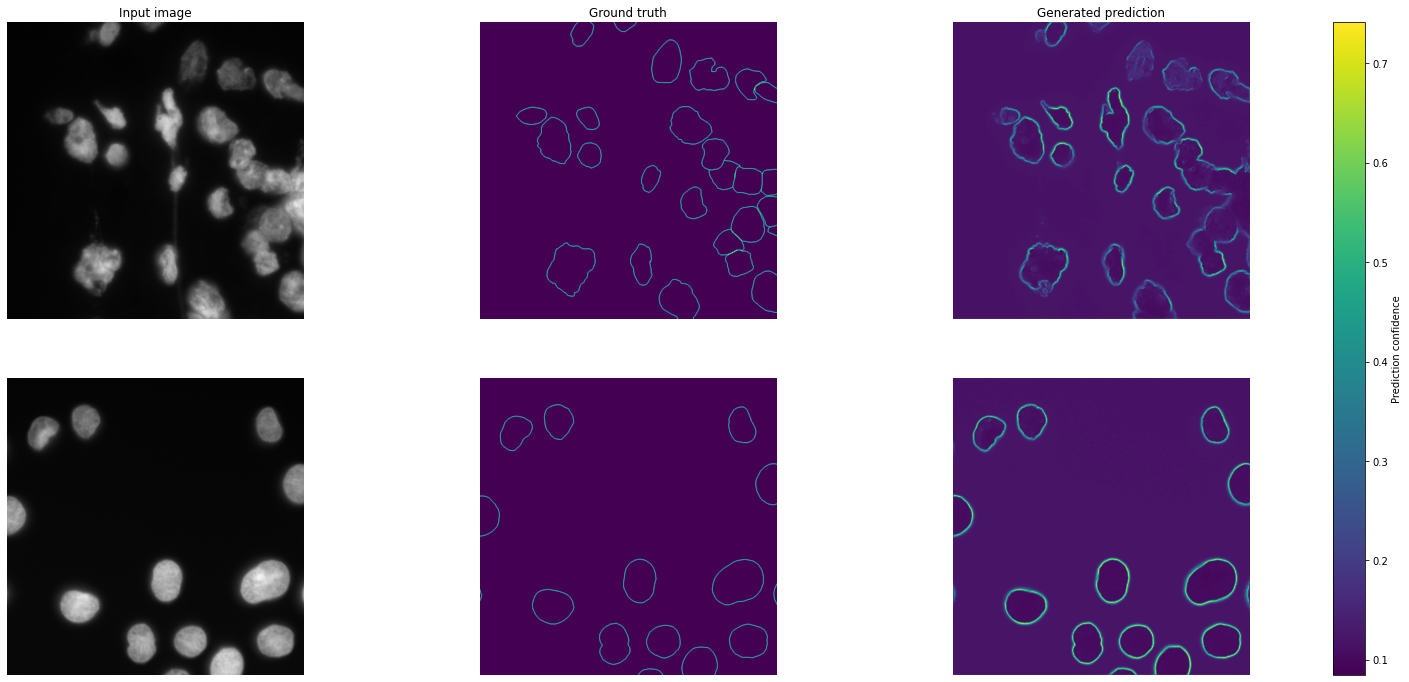

In [45]:
class_index = 2 #@param {type:"slider", min:0, max:2, step:1}
class_index = min(class_index, NUM_CLASSES - 1)
show_results(inputs, labels == class_index, outputs[:, class_index])

We can use this data with either a connected components or a watershed algorithm to obtain an instance segmentation of an image. We'll see later how to do that.

# Stardist Segmentation

We obtain a pre-trained StarDist model from our Google Drive. If you want to train the model yourself, run the other notebook!

In [50]:
!gdown "https://drive.google.com/uc?id=1Xp5lSCOBHc_JX1nnupX8vhzI8CgfXZiu" -O stardist-pretrained.zip
!unzip stardist-pretrained.zip -dstardist-pretrained

Downloading...
From: https://drive.google.com/uc?id=1Xp5lSCOBHc_JX1nnupX8vhzI8CgfXZiu
To: /content/ml-segmentation-project/stardist-pretrained.zip
5.36MB [00:00, 32.7MB/s]
Archive:  stardist-pretrained.zip
  inflating: stardist-pretrained/thresholds.json  
  inflating: stardist-pretrained/config.json  
  inflating: stardist-pretrained/weights_best.h5  


In [51]:
stardist_model = StarDist2D(None, name='stardist-pretrained')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.458502, nms_thresh=0.4.


# Comparing segmentation results

We can now obtain instance segmentations through different methods:

1. U-Net with connected components
2. U-Net with watershed
3. Stardist

As a final step, we visualize them and compare their results.

## Visualizing segmentations

We generate the instance segmentations for a batch of data with the different methods and then plot them.

In [62]:
inputs, _ = next(iter(val_loader))
outputs = model.predict(inputs.to(device))

In [64]:
def show_segmentation_results(input, connected, watershed, stardist, cmap):
    fig = plt.figure(figsize=(13, 13))
    axs = fig.subplots(2, 2).flat
    
    column_labels = ["Input image", "Connected Components", "Watershed", "Stardist"]

    for ax, label in zip(axs, column_labels):
        ax.axis("off")
        ax.set_title(label)
        
    axs[0].imshow(input.squeeze(), cmap="gray")
    axs[1].imshow(connected, interpolation="nearest", cmap=cmap)
    axs[2].imshow(watershed, interpolation="nearest", cmap=cmap)
    axs[3].imshow(stardist, interpolation="nearest", cmap=cmap)
    fig.show()

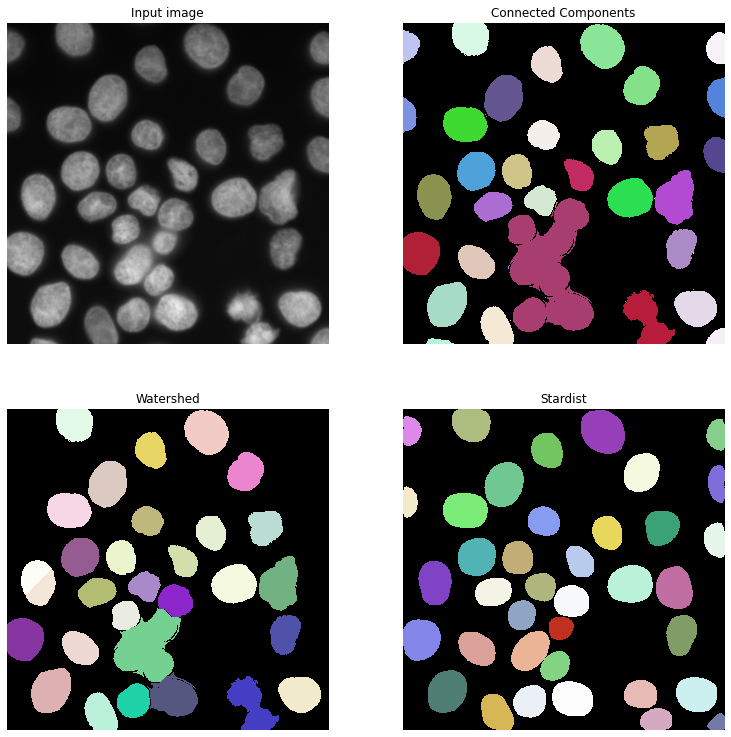

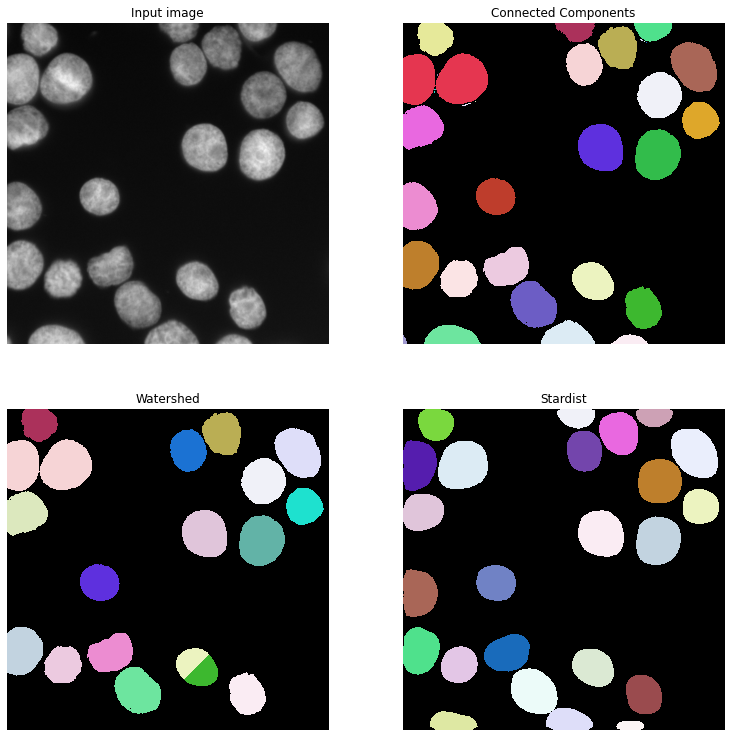

In [65]:
torch.cuda.empty_cache()

for input, output in zip(inputs, outputs):
    input = input.numpy()
    output_classes = output.argmax(dim=0).numpy()
    watershed_output = label_with_watershed(output_classes == 1)
    connected_output = measure.label(output_classes == 1)
    stardist_output, _ = stardist_model.predict_instances(input.squeeze())
    
    show_segmentation_results(
        input,
        connected_output,
        watershed_output,
        stardist_output,
        cmap=random_label_cmap()
    )

## Visualizing the accuracy of the methods

Finally, we compute the accuracy of our methods using the IoU metric and plot them as a function of the IoU threshold.

In [57]:
label_list = []
water_list = []
connec_list = []
star_list = []
UNet_list = []

for inputs, labels in val_loader:
  outputs = model.predict(inputs.to(device)).argmax(dim=1).numpy()
  for i in range(BATCH_SIZE):
    label_list.append(labels[i].numpy().squeeze())
    connec_list.append(measure.label(outputs[i]))
    UNet_list.append(label_with_watershed(outputs[i]))
    pred_star, details = stardist_model.predict_instances(inputs[i].numpy().squeeze())
    star_list.append(pred_star)

In [58]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(connec_list, star_list, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


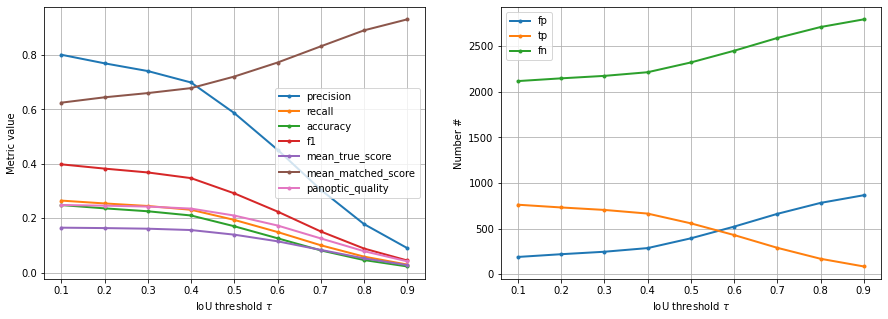

In [59]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

plt.show()